In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
% matplotlib inline
plt.style.use('ggplot')

import seaborn as sns

import cartopy.crs as ccrs
import cartopy.feature as cfeat
import cartopy.io.img_tiles as cimgt

import AISMapPlot as aismap

In [2]:
ais_learners = []
sectors = [0, 1, 2, 3, 4, 5]
sector_borders = [52.8, 4.8, 6.0, 7.2, 8.6, 9.81]
positions = pd.DataFrame([[52.8, np.nan], [np.nan, 4.8], [np.nan, 6.0], [np.nan, 7.2], [np.nan, 8.6], [np.nan, 9.81]],
                         columns = ['Latitude', 'Longitude'])
for s in sectors:
    ais_learners.append(pd.read_pickle('ROT-HAM_learners_01min_s%d.pkl' % (s)))

In [3]:
positions

,Latitude,Longitude
0,52.8,NaN
1,NaN,4.80
2,NaN,6.00
3,NaN,7.20
4,NaN,8.60
5,NaN,9.81


In [4]:
ais_learners[0].head()

,TripID,time,Length,Breadth,Draught,Latitude,Longitude,SOG,COG,TH,...,hour_of_day,weekday,day_of_month,month,sector,mins_to_sector_leave,sector_leave_lat,sector_leave_lon,sector_leave_sog,sector_leave_cog
834543,1000226,2016-06-15 14:57:00,369.0,51.0,13.8,51.97,4.03,5.4,112.3,112.0,...,14,2,15,6,0,301.0,52.8,4.2,12.8,34.3
834550,1000226,2016-06-15 14:58:00,369.0,51.0,13.8,51.97,4.03,5.2,112.4,112.0,...,14,2,15,6,0,300.0,52.8,4.2,12.8,34.3
834566,1000226,2016-06-15 14:59:00,369.0,51.0,13.8,51.97,4.04,5.0,113.2,112.0,...,14,2,15,6,0,299.0,52.8,4.2,12.8,34.3
834343,1000226,2016-06-15 15:00:00,369.0,51.0,13.8,51.96,4.04,4.8,112.8,112.0,...,15,2,15,6,0,298.0,52.8,4.2,12.8,34.3
834348,1000226,2016-06-15 15:01:00,369.0,51.0,13.8,51.96,4.04,4.8,111.2,111.0,...,15,2,15,6,0,297.0,52.8,4.2,12.8,34.3


In [5]:
X = []
y = []
for s in sectors:
    X.append(ais_learners[s][['Latitude', 'Longitude']])
    y.append(ais_learners[s][['sector_leave_lat', 'sector_leave_lon', 'mins_to_sector_leave']])

In [6]:
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import cross_val_score

cv_splits = []
for s in sectors:
    cv_splits.append(list(GroupKFold(n_splits = 10).split(X[s], y[s], groups = ais_learners[s]['TripID'])))

In [7]:
# Retrieve ONE simple train-test split (for each sector)
train_indices = []
test_indices = []
for s in sectors:
    a, b = cv_splits[s][0]
    train_indices.append(a)
    test_indices.append(b)

X_train = []
X_test = []
for s in sectors:
    X_train.append(X[s].iloc[train_indices[s]])
    X_test.append(X[s].iloc[test_indices[s]])

y_train = []
y_test = []
for s in sectors:
    y_train.append(y[s].iloc[train_indices[s]])
    y_test.append(y[s].iloc[test_indices[s]])

In [10]:
from sklearn.neighbors import KNeighborsRegressor

for s in sectors:
    knn_pos = KNeighborsRegressor(n_neighbors = 20)
    scores = cross_val_score(knn_pos, X[s], y[s], cv = cv_splits[s], scoring = 'neg_mean_absolute_error')
    print(scores.mean())

-10.490215271374337
-7.447493020233258
-6.7135031717924365
-9.390639093851238
-13.875114248446803
-5.013786426005548


In [11]:
knn_pos_list = []
for s in sectors:
    knn_pos = KNeighborsRegressor(n_neighbors = 20)
    if s == 0:
        knn_pos.fit(X_train[s], y_train[s]['sector_leave_lon'])
    else:
        knn_pos.fit(X_train[s], y_train[s]['sector_leave_lat'])
    knn_pos_list.append(knn_pos)

In [12]:
knn_pos_list[4].predict([[53.99, 8.17]])

array([53.9505])

In [13]:
# 51.99 4.07
lats = [51.99]
lons = [4.07]
for s in sectors:
    if s == 0:
        print(sector_borders[0])
        lat = sector_borders[0]
        lon = knn_pos_list[0].predict([[lats[-1], lons[-1]]])[0]
    else:
        lat = knn_pos_list[s].predict([[lats[-1], lons[-1]]])[0]
        lon = sector_borders[s]
    lats.append(lat)
    lons.append(lon)
print(lats)
print(lons)

52.8
[51.99, 52.8, 53.442499999999995, 53.681999999999995, 53.863, 53.95000000000001, 53.54999999999999]
[4.07, 4.1850000000000005, 4.8, 6.0, 7.2, 8.6, 9.81]


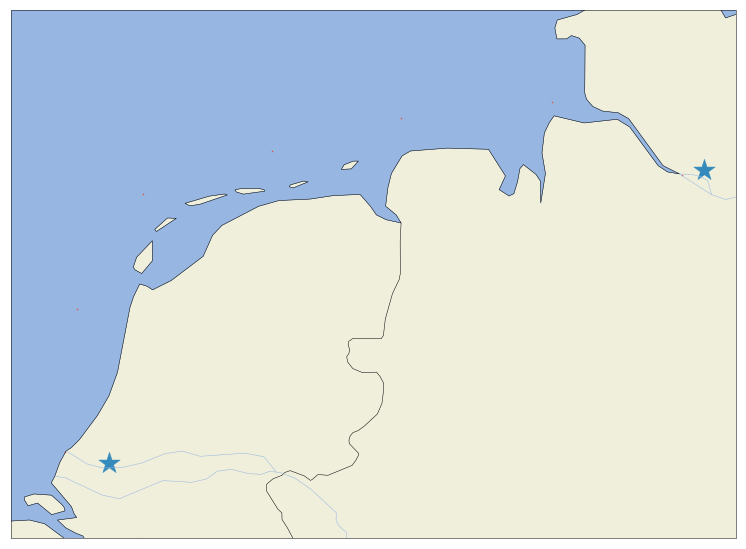

In [14]:
aismap.plot_to_map(size = (13, 13), longitude = pd.Series(lons), latitude = pd.Series(lats))

In [15]:
for s in sectors:
    knn_time = KNeighborsRegressor(n_neighbors = 20)
    scores = cross_val_score(knn_time, X[s], y[s]['mins_to_sector_leave'], cv = cv_splits[s], scoring = 'neg_mean_absolute_error')
    print("%d -> %f" % (s, scores.mean()))

0 -> -31.453920
1 -> -22.320694
2 -> -20.134813
3 -> -28.165721
4 -> -41.624551
5 -> -15.041288


In [16]:
knn_time_list = []
for s in sectors:
    knn_time = KNeighborsRegressor(n_neighbors = 20)
    knn_time.fit(X_train[s], y_train[s]['mins_to_sector_leave'])
    knn_time_list.append(knn_time)

In [17]:
knn_time_list[4].predict([[53.99, 8.17]])[0]

60.6

In [18]:
# Pickle KNN models
import pickle

for s in sectors:
    pos_model = knn_pos_list[s]
    pickle.dump(pos_model, open('../App/Agents/rot_ham_s%d/model_position.pkl' % (s), 'wb'))
    
    time_model = knn_time_list[s]
    pickle.dump(time_model, open('../App/Agents/rot_ham_s%d/model_time.pkl' % (s), 'wb'))

In [19]:
test_loaded = pickle.load(open('../App/Agents/rot_ham_s%d/model_time.pkl' % (4), 'rb'))
test_loaded.predict([[53.99, 8.17]])[0]

60.6

In [20]:
print(knn_time_list[4])
print(test_loaded)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=20, p=2,
          weights='uniform')
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=20, p=2,
          weights='uniform')
